In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [31]:
%load_ext autoreload
%autoreload 2
import Metrica_IO as mio
import Metrica_Viz as mviz
import Metrica_Velocities as mvel
import Metrica_PitchControl as mpc
import Metrica_EPV as mepv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# set up initial path to data
DATADIR = '/Users/jeromekirkpatrick/Desktop/galvanize/sample-data/data'

game_id = 2 # let's look at sample match 2

In [5]:
# read in the event data
events = mio.read_event_data(DATADIR,game_id)

In [6]:
# read in tracking data
tracking_home = mio.tracking_data(DATADIR,game_id,'Home')
tracking_away = mio.tracking_data(DATADIR,game_id,'Away')

Reading team: home
Reading team: away


In [7]:
# Convert positions from metrica units to meters (note change in Metrica's coordinate system since the last lesson)
tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)
events = mio.to_metric_coordinates(events)

In [8]:
# reverse direction of play in the second half so that home team is always attacking from right->left
tracking_home,tracking_away,events = mio.to_single_playing_direction(tracking_home,tracking_away,events)

In [9]:
# Calculate player velocities
# tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True)
# tracking_away = mvel.calc_player_velocities(tracking_away,smoothing=True)
# # **** NOTE *****
# if the lines above produce an error (happens for one version of numpy) change them to the lines below:
# ***************
tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True,filter_='moving_average')
tracking_away = mvel.calc_player_velocities(tracking_away,smoothing=True,filter_='moving_average')

In [21]:
""" *** UPDATES TO THE MODEL: OFFSIDES """
# first get pitch control model parameters
params = mpc.default_model_params()
# find goalkeepers for offside calculation
GK_numbers = [mio.find_goalkeeper(tracking_home),mio.find_goalkeeper(tracking_away)]

In [22]:
# # this step next to make it easy to use game 
# #read in the tracking data for liverpool and the opposition
# tracking_home1 = pd.read_csv('tracking_home1.csv')
# tracking_away1 = pd.read_csv('tracking_home2.csv')

In [23]:
params = mpc.default_model_params(3)

In [24]:
def nearest_attacker(target_position, frame, tracking_home, tracking_away, params, field_dimen = (106.,68.,), n_grid_cells_x = 50):
    pass_frame = frame
    pass_team = 'Away'
    if pass_team=='Home':
        attacking_players = mpc.initialise_players(tracking_homenew.loc[pass_frame],'Home',params)
        defending_players = mpc.initialise_players(tracking_awaynew.loc[pass_frame],'Away',params)
    elif pass_team=='Away':
        defending_players = mpc.initialise_players(tracking_homenew.loc[pass_frame],'Home',params)
        attacking_players = mpc.initialise_players(tracking_awaynew.loc[pass_frame],'Away',params)
    else:
        assert False, "Team in possession must be either home or away"

    nearest_att = np.nanargmin( [p.simple_time_to_intercept(target_position ) for p in attacking_players] )
    return attacking_players[nearest_att].__dict__['id']

In [25]:
#function to find x-coordinate of deepest opposition defender
def last_def(frame,tracking_homenew):
    u = 'Away'
    if u == "Away":
        a1 = tracking_homenew.iloc[f].Home_1_x
        a2 = tracking_homenew.iloc[f].Home_2_x
        a3 = tracking_homenew.iloc[f].Home_3_x
        a4 = tracking_homenew.iloc[f].Home_4_x
        a5 = tracking_homenew.iloc[f].Home_5_x
        a6 = tracking_homenew.iloc[f].Home_6_x
        a7 = tracking_homenew.iloc[f].Home_7_x
        a8 = tracking_homenew.iloc[f].Home_8_x   
        a9 = tracking_homenew.iloc[f].Home_9_x 
        a10 = tracking_homenew.iloc[f].Home_10_x
        a11 = tracking_homenew.iloc[f].Home_11_x
        a12 = tracking_homenew.iloc[f].Home_12_x
        a13 = tracking_homenew.iloc[f].Home_13_x
        a14 = tracking_homenew.iloc[f].Home_14_x
        x=[a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14]
        x = np.array(x)
        x[np.isnan(x)] = 0
        m = np.partition(x, 12)[12]

    return m

In [26]:
def find1(PP,frame,tracking_home,tracking_away,xgrid,ygrid,last):
    for k in range(0,49):
        for i in range(0,31):
            l = (nearest_attackerliv(np.array( [xgrid[k], ygrid[i]] ),frame, tracking_home, tracking_away, params, field_dimen = (106.,68.,), n_grid_cells_x = 50))
            l=l.astype(int)
            if (locx[i][k]>last) and (PP[i][k]>0.5):
                zero[i][k] = zero[i][k]+PP[i][k]
    return

In [27]:
#iterations is number of frames analysed
#interval is difference between two consecutive frames looked at, could be 1,2,3,....
#starting_frame is the first frame to be looked at
def pitch_control_behind_defence(iterations, interval, starting_frame,tracking_homenew, tracking_awaynew, params):
    for j in range(0, iterations):
        k = starting_frame + j*interval
        frame_id = k
        last = last_defliv(frame_id,tracking_homenew)
        p = 'Away'
        PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_frameliv(frame_id, tracking_homenew, tracking_awaynew, params, field_dimen = (106.,68.,), n_grid_cells_x = 50)
        find1(PPCF,frame_id,tracking_homenew,tracking_awaynew,xgrid,ygrid,last)

In [28]:
#to plot pitch control behind defence 
def plot_pitch_control(zero):
    import matplotlib as mpl
    from matplotlib import pyplot
    import numpy as np


    fig = pyplot.figure(2)

    cmap2 = mpl.colors.LinearSegmentedColormap.from_list('my_colormap',
                                           ['green','yellow','orange','red'],
                                           256)

    img2 = pyplot.imshow(zero[:,0:49][0:31],interpolation='nearest',cmap = cmap2,origin='lower')

    pyplot.colorbar(img2,cmap=cmap2)

    fig.savefig("new.png",dpi=600)#save the plot on your desktop

ValueError: too many values to unpack (expected 2)

In [48]:
def my_plot_frame( hometeam, awayteam, figax=None, team_colors=('r','b'), field_dimen = (106.0,68.0), include_player_velocities=False, PlayerMarkerSize=10, PlayerAlpha=0.7, annotate=False ):
    """ plot_frame( hometeam, awayteam )
    
    Plots a frame of Metrica tracking data (player positions and the ball) on a football pitch. All distances should be in meters.
    
    Parameters
    -----------
        hometeam: row (i.e. instant) of the home team tracking data frame
        awayteam: row of the away team tracking data frame
        fig,ax: Can be used to pass in the (fig,ax) objects of a previously generated pitch. Set to (fig,ax) to use an existing figure, or None (the default) to generate a new pitch plot, 
        team_colors: Tuple containing the team colors of the home & away team. Default is 'r' (red, home team) and 'b' (blue away team)
        field_dimen: tuple containing the length and width of the pitch in meters. Default is (106,68)
        include_player_velocities: Boolean variable that determines whether player velocities are also plotted (as quivers). Default is False
        PlayerMarkerSize: size of the individual player marlers. Default is 10
        PlayerAlpha: alpha (transparency) of player markers. Defaault is 0.7
        annotate: Boolean variable that determines with player jersey numbers are added to the plot (default is False)
        
    Returrns
    -----------
       fig,ax : figure and aixs objects (so that other data can be plotted onto the pitch)

    """
    if figax is None: # create new pitch 
        fig,ax = mviz.my_plot_pitch( field_dimen = field_dimen )
    else: # overlay on a previously generated pitch
        fig,ax = figax # unpack tuple
    # plot home & away teams in order
    for team,color in zip( [hometeam,awayteam], team_colors) :
        x_columns = [c for c in team.keys() if c[-2:].lower()=='_x' and c!='ball_x'] # column header for player x positions
        y_columns = [c for c in team.keys() if c[-2:].lower()=='_y' and c!='ball_y'] # column header for player y positions
        ax.plot( team[x_columns], team[y_columns], color+'o', MarkerSize=PlayerMarkerSize, alpha=PlayerAlpha ) # plot player positions
        if include_player_velocities:
            vx_columns = ['{}_vx'.format(c[:-2]) for c in x_columns] # column header for player x positions
            vy_columns = ['{}_vy'.format(c[:-2]) for c in y_columns] # column header for player y positions
            ax.quiver( team[x_columns], team[y_columns], team[vx_columns], team[vy_columns], color=color, scale_units='inches', scale=10.,width=0.0015,headlength=5,headwidth=3,alpha=PlayerAlpha)
        if annotate:
            [ ax.text( team[x]+0.5, team[y]+0.5, x.split('_')[1], fontsize=10, color=color  ) for x,y in zip(x_columns,y_columns) if not ( np.isnan(team[x]) or np.isnan(team[y]) ) ] 
    # plot ball
    ax.plot( hometeam['ball_x'], hometeam['ball_y'], 'wo', markeredgecolor='k', markeredgewidth=1.5, MarkerSize=6, alpha=1.0, LineWidth=0)
    return fig,ax

In [49]:
tracking_home.loc[100,:]

Period           1.000000
Time [s]         4.000000
Home_11_x       46.553080
Home_11_y        0.599080
Home_1_x        15.976320
                  ...    
Home_8_vy        0.374000
Home_8_speed     0.490918
Home_9_vx       -1.351500
Home_9_vy       -2.771000
Home_9_speed     3.083017
Name: 100, Length: 74, dtype: float64

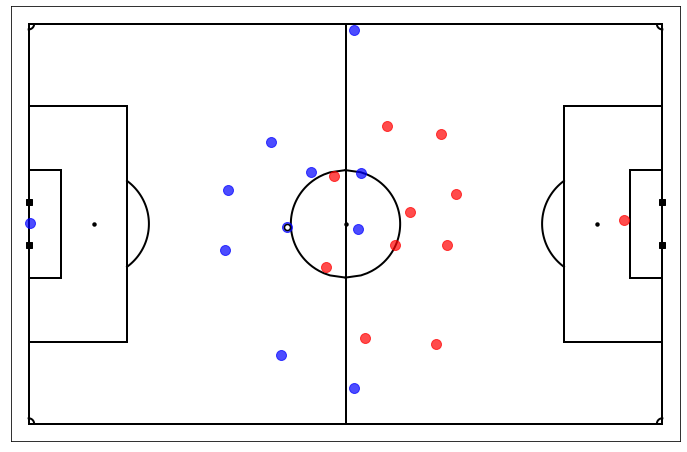

In [51]:
my_plot_frame(tracking_home.loc[100,:],tracking_away.loc[100,:]);

In [53]:
frame = 100 #for finding out pitch control at that instant
PPCF,xgrid,ygrid = mpc.my_generate_pitch_control_for_frame(frame, tracking_home, tracking_away, params, field_dimen = (106.,68.,), n_grid_cells_x = 50, GK_numbers=GK_numbers)
mviz.my_plot_pitchcontrol_for_frame(frame, tracking_home, tracking_away, PPCF, xgrid, ygrid, annotate=False )

ValueError: too many values to unpack (expected 2)

In [39]:
#code for pitch control video, change the starting_frame and end_frame as needed
#here the last goal is accessed
import moviepy.editor as mpy
from moviepy.video.io.bindings import mplfig_to_npimage
import math
starting_frame = 3424
end_frame = 3548
f = 20
def make_frame(t):
    t2 = int(math.ceil(t*f+0.0001)-1)
    #print(t ,t2+starting_frame, 'dscsd')
    PPCF,xgrid,ygrid = mpc.my_generate_pitch_control_for_frame(t2+starting_frame, tracking_home, tracking_away, params, field_dimen = (106.,68.,), n_grid_cells_x = 50, GK_numbers=GK_numbers)
    fig, ax = mviz.my_plot_pitchcontrol_for_frame(t2+starting_frame,  tracking_home, tracking_away, PPCF, xgrid, ygrid, annotate=True ) 
    image = mplfig_to_npimage(fig)
    return image # returns a 8-bit RGB array

clip = mpy.VideoClip(make_frame, duration=((end_frame-starting_frame)/f)).set_fps(f) # 2 seconds
clip.ipython_display()
clip.write_videofile("video.mp4")#video file is saved

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

In [ ]:
PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_frameliv(5, tracking_homenew, tracking_awaynew, params, field_dimen = (106.,68.,), n_grid_cells_x = 50)
locx = PPCF.copy()
zero = PPCF.copy()

for k in range(0, 50):
    for i in range(0,32):
        locx[i][k] = xgrid[k]
        zero[i][k] = 0

In [ ]:
#to plot pitch control behind defence for a particular 20 frames starting from 1, with jump of 5 frames each time
iterations = 20
interval = 5
starting_frame = 1
for k in range(0, 50):
    for i in range(0,32):
        zero[i][k] = 0
liverpool_pitch_control_behind_defence(iterations,interval,starting_frame,tracking_homenew, tracking_awaynew, params)
plot_pitch_control(zero)